In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mne
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 

**Load data from csv files.**

In [3]:
df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_S_feature.csv", header = 0)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:1: SyntaxWarning: invalid escape sequence '\F'
  df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:2: SyntaxWarning: invalid escape sequence '\F'
  df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:3: SyntaxWarning: invalid escape sequence '\F'
  df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Gra

In [4]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


**Do some basic data preprocessing before performing feature selection.**

Fill in missing data with the mode of its column.

In [5]:
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

Drop the leftmost column of each dataframe because it is just an ID number.

In [6]:
df_A = df_A.iloc[:, 1:] 
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [7]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


**Feature selection:**

In [18]:
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    print("----------STARTING FEATURE SELECTION----------")
    y = df.iloc[:, -1]
    
    # Use recursive feature elimination with cross validation to reduce the dimensionality of the data for each EEG cap channel.
    
    print("----------STARTING RECURSIVE FEATURE ELIMINATION----------")
    start_column_index = 0
    num_features_kept_rfe = 0
    kept_columns_rfe = [] # list of names of columns that are kept

    for i in range(32):
        #print("EEG Cap Channel #", i)
        # Ignore the ratios (e.g. theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns
        
        # decision tree classifier
        dt_classifier = DecisionTreeClassifier() # Note: The features are randomly permuted. For deterministic results, set random_state to a fixed integer.
        # recursive feature elimination with cross validation
        rfecv = RFECV(estimator = dt_classifier, min_features_to_select = 1, cv = StratifiedKFold(), scoring = 'accuracy')
        rfecv.fit(X, y)
        
        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        num_features_kept_rfe += rfecv.n_features_
        
        #print("Optimal number of features : %d" % rfecv.n_features_)
        #print("Columns kept in this iteration:", curr_columns[rfecv.support_])
        
        start_column_index += 14
    print("----------FINISHED RECURSIVE FEATURE ELIMINATION----------")
    
    df_after_rfe = df[kept_columns_rfe]
    print("number of features kept after recursive feature elimination:", num_features_kept_rfe)
    
    X = df_after_rfe
    curr_columns = X.columns

    # Use PCA to further reduce the dimensionality of the dataset.
    print("----------STARTING PCA----------")
    # Scale the data.
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_X= scaler.transform(X)

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit(scaled_X)
    pca_result = pca.transform(scaled_X)
    print("----------FINISHED PCA----------")
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    #print("explained variance ratio: ", explained_variance_ratio)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    #print("cumulative variance ratio: ", cumulative_variance_ratio)
    #print(cumulative_variance_ratio >= 0.8)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = curr_columns[:components_for_threshold]
    # print("Columns needed for", threshold * 100, "% explained variance:")
    # print(needed_columns)
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 165
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 22


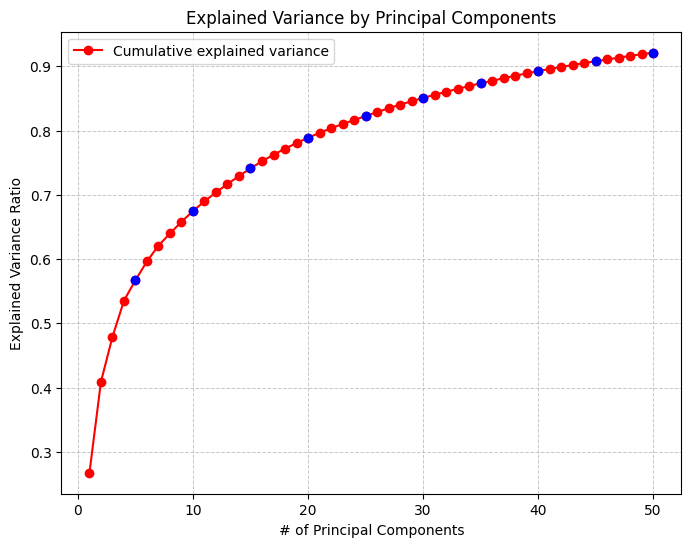

final kept columns:
    0.psd_delta   0.psd_beta  0.psd_gamma  0.delta_rel_power  \
0  14850.830823  6950.560915  3047.582095           0.059237   
1  14838.280527  8087.625726  2855.607519           0.150847   
2   7143.715839  4200.151132  2838.155117           0.082685   
3   7143.570136  4200.428316  2764.924613           0.032636   
4  19573.432251  6509.398324  2423.619039           0.198891   

   0.theta_rel_power  1.psd_alpha   1.psd_beta  1.theta_rel_power  \
0           0.199444  5518.074527  5824.969235           0.199646   
1           0.134471  3995.388885  6269.167711           0.126185   
2           0.319816  5254.756740  3878.494666           0.301774   
3           0.173594  5799.293682  3844.336500           0.057890   
4           0.162208  6277.230350  4717.883216           0.110838   

    2.psd_delta   2.psd_theta  ...  2.delta_rel_power  2.theta_rel_power  \
0   8039.972356  10515.873942  ...           0.078386           0.200349   
1   2524.927423   9608.82474

,0.psd_delta,0.psd_beta,0.psd_gamma,0.delta_rel_power,0.theta_rel_power,1.psd_alpha,1.psd_beta,1.theta_rel_power,2.psd_delta,2.psd_theta,...,2.delta_rel_power,2.theta_rel_power,2.alpha_rel_power,3.psd_theta,3.psd_alpha,4.psd_alpha,4.psd_beta,5.psd_delta,5.psd_alpha,5.psd_beta
0,14850.830823,6950.560915,3047.582095,0.059237,0.199444,5518.074527,5824.969235,0.199646,8039.972356,10515.873942,...,0.078386,0.200349,0.083750,13819.209504,4167.674765,6959.259471,5473.184804,9959.544828,7077.922378,4337.362145
1,14838.280527,8087.625726,2855.607519,0.150847,0.134471,3995.388885,6269.167711,0.126185,2524.927423,9608.824749,...,0.065675,0.134126,0.053252,13511.512183,4690.117540,6671.478508,7251.832429,11531.268301,5167.001768,5545.503702
2,7143.715839,4200.151132,2838.155117,0.082685,0.319816,5254.756740,3878.494666,0.301774,11914.922522,16710.419354,...,0.149521,0.288982,0.118431,12812.601964,4517.164653,6049.473059,4200.371424,6653.416894,4231.435900,3521.503845
3,7143.570136,4200.428316,2764.924613,0.032636,0.173594,5799.293682,3844.336500,0.057890,7769.417844,4775.209063,...,0.104521,0.048319,0.102402,6995.441331,5518.713670,7633.505250,3656.999796,2855.120925,6729.678711,3406.974867
4,19573.432251,6509.398324,2423.619039,0.198891,0.162208,6277.230350,4717.883216,0.110838,18421.953705,14419.819060,...,0.234565,0.103856,0.095289,12940.749857,7851.454295,8684.931093,5528.748439,10903.669662,6108.959048,4617.153174


In [19]:
df_A_preprocessed = perform_feature_selection(df = df_A, variance_threshold=0.8)
df_A_preprocessed.head()

In [20]:
df_A_preprocessed.to_csv('Datasets/df_A_preprocessed.csv')

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 194
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 24


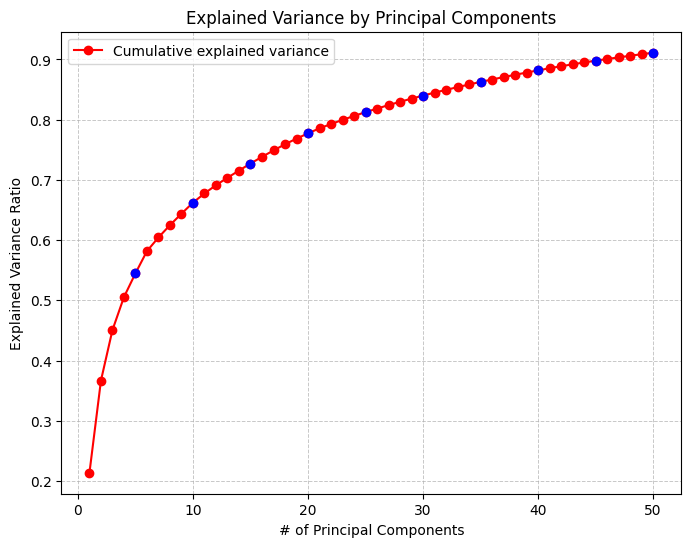

final kept columns:
    0.psd_delta   0.psd_theta   0.psd_alpha    0.psd_beta   0.psd_gamma  \
0  28147.941302  20812.122950  28903.253294  11045.919340  10097.405409   
1  22618.036566  42645.052420  24222.965505  15327.997675   7771.031388   
2  43601.788099  32732.024724  25489.561827  15637.863125   6656.028792   
3  42496.747857  38829.089771  30560.134074  12146.879633   8309.699314   
4  26204.813555  12877.184706   9059.280872  11891.181482  14946.075982   

   0.spectral_entropy_value  0.delta_rel_power  0.beta_rel_power  \
0                  4.682997           0.126007          0.288060   
1                  4.881996           0.103916          0.406341   
2                  4.980213           0.152932          0.352012   
3                  4.763782           0.144180          0.229902   
4                  4.568809           0.096144          0.262839   

    1.psd_delta   1.psd_theta  ...  1.theta_rel_power  1.alpha_rel_power  \
0  31541.470105  29954.967206  ...          

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.delta_rel_power,0.beta_rel_power,1.psd_delta,1.psd_theta,...,1.theta_rel_power,1.alpha_rel_power,1.beta_rel_power,2.psd_delta,2.psd_theta,2.psd_alpha,2.psd_beta,2.psd_gamma,2.spectral_entropy_value,2.delta_rel_power
0,28147.941302,20812.122950,28903.253294,11045.919340,10097.405409,4.682997,0.126007,0.288060,31541.470105,29954.967206,...,0.207707,0.167122,0.270814,34938.513792,33673.811526,21891.815170,13745.843523,10897.486121,4.922720,0.137969
1,22618.036566,42645.052420,24222.965505,15327.997675,7771.031388,4.881996,0.103916,0.406341,39936.522448,51649.360158,...,0.144991,0.127921,0.405022,36819.225771,48968.262835,27692.934829,18368.858430,12772.993129,4.849991,0.082822
2,43601.788099,32732.024724,25489.561827,15637.863125,6656.028792,4.980213,0.152932,0.352012,64146.785166,33271.567752,...,0.130796,0.108978,0.418899,66980.080825,32941.886308,24145.639485,23829.755856,7233.061650,5.046028,0.142731
3,42496.747857,38829.089771,30560.134074,12146.879633,8309.699314,4.763782,0.144180,0.229902,33907.780297,50108.464686,...,0.185689,0.128072,0.253308,26387.037209,56582.287392,16128.611929,17794.462862,10245.559966,4.993238,0.031872
4,26204.813555,12877.184706,9059.280872,11891.181482,14946.075982,4.568809,0.096144,0.262839,37629.361928,17296.463743,...,0.044145,0.036846,0.324067,46289.794364,25623.407990,20632.008824,22215.895817,19825.541364,4.079599,0.081317


In [21]:
df_M_preprocessed = perform_feature_selection(df = df_M, variance_threshold=0.8)
df_M_preprocessed.head()

In [23]:
df_M_preprocessed.to_csv('Datasets/df_M_preprocessed.csv')

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 185
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 22


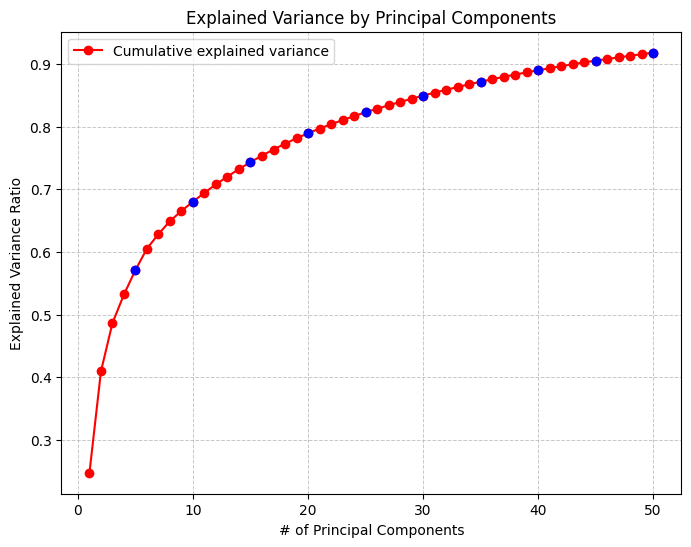

final kept columns:
    0.psd_delta  0.psd_gamma   1.psd_delta   1.psd_theta  1.psd_alpha  \
0   9994.605340  1391.927018   9257.775317   7265.036422  7690.433996   
1  14145.852129  1267.961710  10435.260425   3644.720023  2613.103811   
2  10178.565631   756.718130   4620.447414  10058.027260  7519.625489   
3  16698.788741  1156.874710  17008.405306   2634.528149  7967.808412   
4   5514.739540   938.632292   5870.110121   9069.907815  6995.540680   

    1.psd_beta  1.spectral_entropy_value  1.delta_rel_power  \
0  5163.761781                  4.939184           0.135241   
1  2299.748262                  4.803097           0.218845   
2  4332.200640                  4.710522           0.061643   
3  3832.212650                  4.304630           0.300044   
4  3168.696298                  4.495017           0.066728   

   1.alpha_rel_power   2.psd_delta  ...  2.psd_gamma  \
0           0.114774   7741.132087  ...  1654.873051   
1           0.126965   8089.972913  ...   729.3034

,0.psd_delta,0.psd_gamma,1.psd_delta,1.psd_theta,1.psd_alpha,1.psd_beta,1.spectral_entropy_value,1.delta_rel_power,1.alpha_rel_power,2.psd_delta,...,2.psd_gamma,2.spectral_entropy_value,2.beta_rel_power,3.psd_delta,4.psd_beta,4.psd_gamma,4.spectral_entropy_value,4.alpha_rel_power,5.psd_delta,5.psd_theta
0,9994.605340,1391.927018,9257.775317,7265.036422,7690.433996,5163.761781,4.939184,0.135241,0.114774,7741.132087,...,1654.873051,4.911795,0.389903,9661.907784,2759.863513,1367.442590,4.903859,0.152333,10391.923934,6563.189454
1,14145.852129,1267.961710,10435.260425,3644.720023,2613.103811,2299.748262,4.803097,0.218845,0.126965,8089.972913,...,729.303425,4.831397,0.348480,9912.301749,4268.471560,1328.496629,4.720588,0.178973,10759.386823,5140.116910
2,10178.565631,756.718130,4620.447414,10058.027260,7519.625489,4332.200640,4.710522,0.061643,0.163435,4006.286048,...,897.488675,4.728050,0.360312,6328.599401,4956.644722,686.523446,4.467537,0.193102,7434.668102,15221.244517
3,16698.788741,1156.874710,17008.405306,2634.528149,7967.808412,3832.212650,4.304630,0.300044,0.180555,15674.177770,...,808.399091,4.333768,0.410303,12758.430345,3122.330885,1096.519798,4.412611,0.387529,9657.369114,6555.805098
4,5514.739540,938.632292,5870.110121,9069.907815,6995.540680,3168.696298,4.495017,0.066728,0.329012,5633.436192,...,1046.059848,4.624343,0.325384,6800.785099,3283.993904,761.640077,4.356629,0.377105,5092.783874,8155.118138


In [24]:
df_S_preprocessed = perform_feature_selection(df = df_S, variance_threshold=0.8)
df_S_preprocessed.head()

In [25]:
df_S_preprocessed.to_csv('Datasets/df_S_preprocessed.csv')

**Implement the decision tree for detecting stress levels.**

**MAYBE COME BACK LATER TO THIS?**

Preprocess the data (There are 32 electrodes and 450 columns total, so 14 columns per electrode).

PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

FFS: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/


In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame: # COME BACK LATER
    data_arr = (data.to_numpy()).T
    channel_names = list(df_A.columns)  
    channel_types = ['eeg'] * len(channel_names) 
    info = mne.create_info(ch_names = channel_names, ch_types = channel_types)
    raw_arr = mne.io.RawArray(data_arr, info)
    raw_arr.filter(1, 40)
    
    # Perform ICA 
    ica = mne.preprocessing.ICA(n_components = 3)
    ica.fit(raw_arr)
    ica.exclude = ica.find_bads_eog(raw_arr)[0]
    raw_ica_cleaned = ica.apply(raw_arr.copy())
    
    # Convert cleaned data back into pandas DataFrame
    processed_data = (raw_ica_cleaned.get_data()).T
    df_processed = pd.DataFrame(processed_data, columns = channel_names)
    raw_ica_cleaned.plot()
    return df_processed
    